# Particle Swarm Optimisation

## -> Sphere Function

In [36]:
import numpy as np
import itertools
import pandas as pd
import math
import seaborn as sns
import matplotlib.pyplot as plt
import random

The following will be the goal ("fitness") function. Here it is to be minimised.

## Sphere Function

In [37]:
def sphere_function(pos,dim):
    big_sum = 0
    for i in range(dim):
        big_sum = big_sum + pos[i]**2
    return big_sum

## Rastrigin Function

In [38]:
def rastrigin_function(pos,dim):
    big_sum = 10*dim
    for i in range(dim):
        big_sum = big_sum + pos[i]**2 - 10*math.cos(2*math.pi*pos[i])
    return big_sum

## Algorithm

In [39]:
class Particle: # all the material that is relavant at the level of the individual particles
    
    def __init__(self, dim, minx, maxx):
        self.position = np.random.uniform(low=minx, high=maxx, size=dim)
        self.velocity = np.random.uniform(low=-0.1, high=0.1, size=dim)
        self.best_particle_pos = self.position
        self.dim = dim

        self.fitness = sphere_function(self.position,dim)
        self.best_particle_fitness = self.fitness   # we couldd start with very large number here, 
                                                    #but the actual value is better in case we are lucky 
                
    def setPos(self, pos):
        self.position = pos
        self.fitness = sphere_function(self.position,self.dim)
        if self.fitness<self.best_particle_fitness:     # to update the personal best both 
                                                        # position (for velocity update) and
                                                        # fitness (the new standard) are needed
                                                        # global best is update on swarm leven
            self.best_particle_fitness = self.fitness
            self.best_particle_pos = pos

    def updateVel(self, inertia, a1, a2, a3, best_self_pos, best_swarm_pos, swarm):
                # Here we use the canonical version
                # V <- inertia*V + a1r1 (peronal_best - current_pos) + a2r2 (global_best - current_pos)
        cur_vel = self.velocity
        r1 = np.random.uniform(low=0, high=1, size = self.dim)
        r2 = np.random.uniform(low=0, high=1, size = self.dim)
        r3 = np.random.uniform(low=0, high=1, size = self.dim)
        a1r1 = np.multiply(a1, r1)
        a2r2 = np.multiply(a2, r2)
        best_self_dif = np.subtract(best_self_pos, self.position)
        best_swarm_dif = np.subtract(best_swarm_pos, self.position)
        
        # Adding repulsion
#         repulsion_component = a3*calculate_z(swarm,self.position,r3)
        
        result = inertia*cur_vel + np.multiply(a1r1, best_self_dif) + np.multiply(a2r2, best_swarm_dif)
        return result


In [40]:
def calculate_z(particle_swarm,particle,r3):
    result = -sum([np.divide(
        (np.multiply(r3,np.subtract(particle_other.position,particle))),
        (np.subtract(particle_other.position,particle)@np.subtract(particle_other.position,particle))
        )
        for particle_other in particle_swarm])
    return result

In [41]:
class PSO: # all the material that is relavant at swarm leveel

    def __init__(self, w, a1, a2, a3, dim, population_size, time_steps, search_range):

        self.w = w # Inertia
        self.a1 = a1 # Attraction to personal best
        self.a2 = a2 # Attraction to global best
        self.a3 = a3
        self.dim = dim
        self.population_size = population_size

        self.swarm = [Particle(dim,-search_range,search_range) for i in range(population_size)]
        self.time_steps = time_steps

        self.best_swarm_pos = np.random.uniform(low=-500, high=500, size=dim)
        self.best_swarm_fitness = 1e100

    def run(self):
        bests = []
        for t in range(self.time_steps):
#             if t > 300:
#                return bests[len(bests)-1],t
            
            counter_inefficient_particles = 0
            for p in range(len(self.swarm)):
                
                # Particle and his updated position
                particle = self.swarm[p]
                new_position = particle.position + particle.updateVel(self.w, self.a1, self.a2, self.a3,
                                                                      particle.best_particle_pos, 
                                                                      self.best_swarm_pos,self.swarm)    
                    
# RESTRICTIONS!
                if new_position@new_position > 1.0e+18: 
                    return bests[len(bests)-1],self.time_steps

#                 if change_direction(particle.position,new_position,self.dim)==False:
#                     counter_inefficient_particles = counter_inefficient_particles+1
 
                self.swarm[p].setPos(new_position)
                new_fitness = sphere_function(new_position,self.dim)

                if new_fitness < self.best_swarm_fitness:  
                    self.best_swarm_fitness = new_fitness
                    self.best_swarm_pos = new_position
                    
            bests.append(self.best_swarm_fitness)


#             if counter_inefficient_particles/self.population_size>0.99:
#                 return bests[len(bests)-1],t
        
        
        return bests[len(bests)-1],t

In [42]:
def change_direction(old_position, new_position, dim):
    delta_vector = old_position.position - new_position
    delta_sphere = (old_position-new_position)@(old_position-new_position)
    if delta_sphere < 0.1*dim:
        return False
    return True

# Sphere function

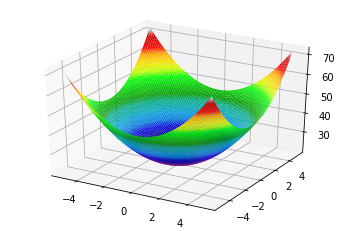

In [43]:
# Sphere

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm 
from mpl_toolkits.mplot3d import Axes3D 
 
X = np.linspace(-5.12, 5.12, 100)     
Y = np.linspace(-5.12, 5.12, 100)     
X, Y = np.meshgrid(X, Y) 

Z = (X**2) + (Y**2) + 20
 
fig = plt.figure() 
ax = fig.gca(projection='3d') 
ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
  cmap=cm.nipy_spectral, linewidth=0.08,
  antialiased=True)    
# plt.imshow(Z)
plt.show()

## Finding best Alpha1 and Alpha2

In [44]:
alpha1 = np.linspace(-5.12,5.12,30)
alpha2 = np.linspace(-5.12,5.12,30)
# w = np.linspace(0,1,100)
w = 30*[0.7]

# random_combinations = random.sample(set(itertools.product(w,alpha1,alpha2)), 1000)
all_possible_combinations = list(set(itertools.product(w,alpha1, alpha2)))

def automator(random_combinations):
    output = []
    for params in random_combinations:
            weight = params[0]
            alpha1 = params[1]
            alpha2 = params[2]
            best_score,num_runs = PSO(dim=2, w=weight, a1=alpha1, a2=alpha2, a3=2.02, population_size=3, time_steps=1000, search_range=5.12).run()
            output.append((weight,alpha1,alpha2,best_score,num_runs))
    return output
    
result = automator(all_possible_combinations)

df = pd.DataFrame(result, columns=['w', 'alpha 1', 'alpha 2', 'best_score', 'num_runs'])
df.sort_values('best_score', inplace=True)
print(df)

       w   alpha 1   alpha 2    best_score  num_runs
198  0.7  1.235862  2.295172  6.603268e-09       999
439  0.7  0.529655  3.354483  7.452444e-09       999
71   0.7  3.707586 -1.235862  8.458936e-09       999
852  0.7  0.529655  1.942069  1.489361e-08       999
288  0.7  2.648276  1.588966  1.509968e-08       999
..   ...       ...       ...           ...       ...
78   0.7  3.354483  4.413793  3.844756e+06      1000
768  0.7 -0.529655 -4.766897  3.943580e+06      1000
715  0.7 -4.766897  5.120000  4.271152e+06      1000
595  0.7 -4.766897 -5.120000  4.387917e+06      1000
285  0.7 -3.354483  4.766897  5.066915e+06      1000

[900 rows x 5 columns]


In [45]:
df.iloc[0]['best_score']

6.603267649201522e-09

In [46]:
best_score,num_runs = PSO(dim=10, w=0.7, a1=2.02, a2=2.02, a3=2.02, population_size=3, time_steps=1000, search_range=5.12).run()
print(best_score)
print(num_runs)

0.053488013473509115
999


In [47]:
df["num_runs"].mean()

999.7366666666667

### Plotting alpha1 vs alpha2

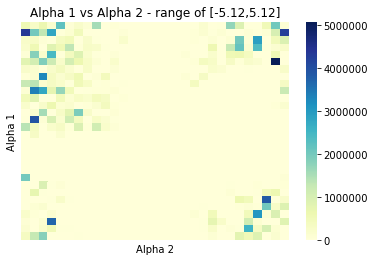

In [48]:
a1 = df.iloc[:,[1]]
a2 = df.iloc[:,[2]]
data = df.iloc[:,[1,2,3]]
data = data.pivot(index='alpha 1', columns='alpha 2', values='best_score')
sns.heatmap(data,xticklabels=False,yticklabels=False,cmap='YlGnBu')
# plt.imshow(data, cmap='hot', interpolation='nearest')
plt.title('Alpha 1 vs Alpha 2 - range of [-5.12,5.12]')
plt.xlabel("Alpha 2")
plt.ylabel("Alpha 1")


plt.savefig('alpha1_alpha2_sphere.pdf') 

plt.show()

## Finding best w

     w   alpha 1   alpha 2    best_score  num_run
4 -1.0  1.235862  2.295172  1.215581e-08      999
           w   alpha 1   alpha 2    best_score  num_run
4  -1.000000  1.235862  2.295172  6.547622e-07      999
9  -0.931034  1.235862  2.295172  1.083817e-06      999
19 -0.862069  1.235862  2.295172  3.078406e-07      999
17 -0.793103  1.235862  2.295172  4.721741e-06      999
2  -0.724138  1.235862  2.295172  3.897548e-08      999
18 -0.655172  1.235862  2.295172  2.084761e-06      999
26 -0.586207  1.235862  2.295172  2.147423e-07      999
27 -0.517241  1.235862  2.295172  1.464939e-06      999
14 -0.448276  1.235862  2.295172  4.337651e-08      999
15 -0.379310  1.235862  2.295172  3.779107e-07      999
16 -0.310345  1.235862  2.295172  5.253269e-08      999
7  -0.241379  1.235862  2.295172  2.882573e-08      999
12 -0.172414  1.235862  2.295172  4.176152e-08      999
24 -0.103448  1.235862  2.295172  1.310712e-08      999
23 -0.034483  1.235862  2.295172  7.547824e-10      999
10  

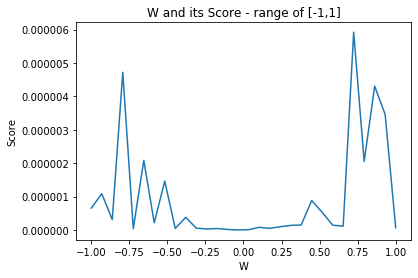

In [52]:
# Now to find the best w - let us take the alpha values for which we got the best result:
best_result = df.iloc[[0],:]
print(best_result)
alpha1 = best_result.iloc[0]['alpha 1']
alpha2 = best_result.iloc[0]['alpha 2']

w = np.linspace(-1,1,30)

all_possible_combinations = list(set(itertools.product(w,30*[alpha1], 30*[alpha2])))

result = automator(all_possible_combinations)
df = pd.DataFrame(result, columns=['w', 'alpha 1', 'alpha 2', 'best_score','num_run'])
df.sort_values('w', inplace=True)

print(df)

w = df.iloc[:,[0]]
a1 = df.iloc[:,[1]]
a2 = df.iloc[:,[2]]
score = df.iloc[:,[3]]
data = df.iloc[:,[0,2,3]]
plt.plot(w,score)
# plt.imshow(data, cmap='hot', interpolation='nearest')
plt.title('W and its Score - range of [-1,1]')
plt.xlabel("W")
plt.ylabel("Score")


plt.savefig('w_sphere.pdf') 

plt.show()

In [53]:






# df.sort_values('w', inplace=True)


df.sort_values('best_score', inplace=True)

print(df)

           w   alpha 1   alpha 2    best_score  num_run
23 -0.034483  1.235862  2.295172  7.547824e-10      999
10  0.034483  1.235862  2.295172  7.726470e-09      999
24 -0.103448  1.235862  2.295172  1.310712e-08      999
7  -0.241379  1.235862  2.295172  2.882573e-08      999
2  -0.724138  1.235862  2.295172  3.897548e-08      999
12 -0.172414  1.235862  2.295172  4.176152e-08      999
14 -0.448276  1.235862  2.295172  4.337651e-08      999
0   0.172414  1.235862  2.295172  4.731396e-08      999
16 -0.310345  1.235862  2.295172  5.253269e-08      999
25  1.000000  1.235862  2.295172  7.099546e-08      999
5   0.103448  1.235862  2.295172  7.692360e-08      999
8   0.241379  1.235862  2.295172  9.702249e-08      999
29  0.655172  1.235862  2.295172  1.113481e-07      999
1   0.310345  1.235862  2.295172  1.357621e-07      999
3   0.586207  1.235862  2.295172  1.438238e-07      999
21  0.379310  1.235862  2.295172  1.485898e-07      999
26 -0.586207  1.235862  2.295172  2.147423e-07  

### Performance based on N

           w   alpha 1   alpha 2    best_score  num_runs   n
67  0.176552  2.295172  1.010167      0.000026       999  68
87  0.176552  2.295172  1.010167      0.000043       999  88
78  0.176552  2.295172  1.010167      0.000046       999  79
92  0.176552  2.295172  1.010167      0.000047       999  93
98  0.176552  2.295172  1.010167      0.000048       999  99
..       ...       ...       ...           ...       ...  ..
4   0.176552  2.295172  1.010167   7925.665822       999   5
2   0.176552  2.295172  1.010167   8732.143771       999   3
3   0.176552  2.295172  1.010167   9412.466177       999   4
1   0.176552  2.295172  1.010167  16644.753065       999   2
0   0.176552  2.295172  1.010167  37657.315314       999   1

[99 rows x 6 columns]


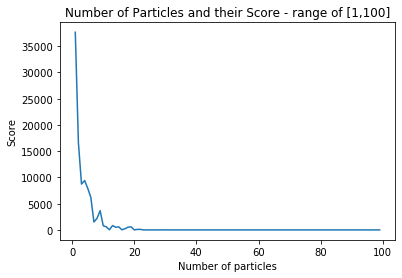

In [54]:
def automator_n(n_values,params):
    output = []
    for n in range(1,n_values):
        weight = params[0]
        alpha1 = params[1]
        alpha2 = params[2]
        best_score,num_runs = PSO(dim=10, w=weight, a1=alpha1, a2=alpha2, a3=1, population_size=n, time_steps=1000, search_range=100).run()
        output.append((weight,alpha1,alpha2,best_score,num_runs,n))
    return output

params = [0.176552,2.295172,1.010167]
n_values = 100
result = automator_n(n_values,params)

df = pd.DataFrame(result, columns=['w', 'alpha 1', 'alpha 2', 'best_score', 'num_runs','n'])

# printing the dataframe
df.sort_values('best_score', inplace=True)
print(df)

# plotting the data
df.sort_values('n', inplace=True)

w = df.iloc[:,[0]]
a1 = df.iloc[:,[1]]
a2 = df.iloc[:,[2]]
score = df.iloc[:,[3]]
data = df.iloc[:,[0,2,3]]
n = df.iloc[:,[5]]
plt.plot(n,score)
# plt.imshow(data, cmap='hot', interpolation='nearest')
plt.title('Number of Particles and their Score - range of [1,100]')
plt.xlabel("Number of particles")
plt.ylabel("Score")


plt.savefig('n_particles_sphere.pdf') 
plt.show()

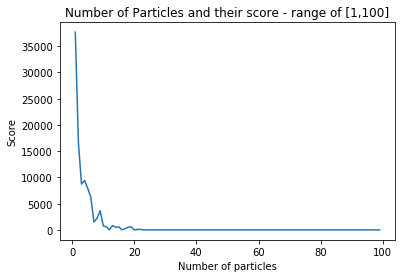

In [55]:
w = df.iloc[:,[0]]
a1 = df.iloc[:,[1]]
a2 = df.iloc[:,[2]]
score = df.iloc[:,[3]]
data = df.iloc[:,[0,2,3]]
n = df.iloc[:,[5]]
plt.plot(n,score)
# plt.imshow(data, cmap='hot', interpolation='nearest')
plt.title('Number of Particles and their score - range of [1,100]')
plt.xlabel("Number of particles")
plt.ylabel("Score")


plt.savefig('n_particles_sphere.pdf') 


plt.show()


### Performanced based on D

           w   alpha 1   alpha 2    best_score  num_runs   d
0   0.176552  2.295172  1.010167  1.964144e-16       999   1
1   0.176552  2.295172  1.010167  3.613313e-09       999   2
2   0.176552  2.295172  1.010167  5.942871e-09       999   3
3   0.176552  2.295172  1.010167  1.037109e-07       999   4
4   0.176552  2.295172  1.010167  2.291041e-06       999   5
5   0.176552  2.295172  1.010167  7.655209e-06       999   6
6   0.176552  2.295172  1.010167  2.919172e-05       999   7
7   0.176552  2.295172  1.010167  3.314870e-05       999   8
8   0.176552  2.295172  1.010167  7.902425e-05       999   9
9   0.176552  2.295172  1.010167  1.222256e-04       999  10
10  0.176552  2.295172  1.010167  1.873902e-04       999  11
13  0.176552  2.295172  1.010167  2.470152e-04       999  14
11  0.176552  2.295172  1.010167  2.776204e-04       999  12
14  0.176552  2.295172  1.010167  3.803599e-04       999  15
12  0.176552  2.295172  1.010167  3.979235e-04       999  13
16  0.176552  2.295172  

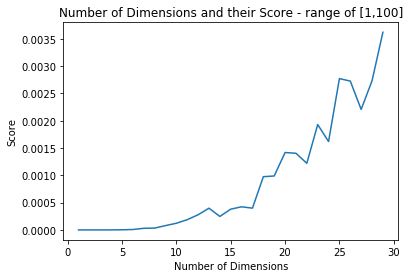

In [57]:
def automator_d(d_values,params):
    output = []
    for d in range(1,d_values):
        weight = params[0]
        alpha1 = params[1]
        alpha2 = params[2]
        best_score,num_runs = PSO(dim=d, w=weight, a1=alpha1, a2=alpha2, a3=1, population_size=35, time_steps=1000, search_range=5.12).run()
        output.append((weight,alpha1,alpha2,best_score,num_runs,d))
    return output

params = [0.176552,2.295172,1.010167]
d_values = 30
result = automator_d(d_values,params)

df = pd.DataFrame(result, columns=['w', 'alpha 1', 'alpha 2', 'best_score', 'num_runs','d'])

# printing the dataframe
df.sort_values('best_score', inplace=True)
print(df)

# plotting the data
df.sort_values('d', inplace=True)

w = df.iloc[:,[0]]
a1 = df.iloc[:,[1]]
a2 = df.iloc[:,[2]]
score = df.iloc[:,[3]]
data = df.iloc[:,[0,2,3]]
d = df.iloc[:,[5]]
plt.plot(d,score)
# plt.imshow(data, cmap='hot', interpolation='nearest')
plt.title('Number of Dimensions and their Score - range of [1,100]')
plt.xlabel("Number of Dimensions")
plt.ylabel("Score")


plt.savefig('d_dimensions_sphere.pdf') 

plt.show()

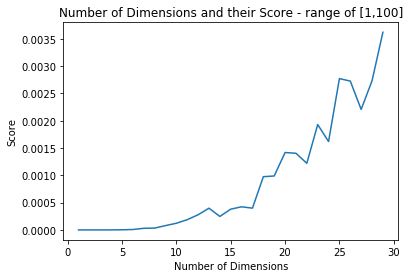

In [58]:
w = df.iloc[:,[0]]
a1 = df.iloc[:,[1]]
a2 = df.iloc[:,[2]]
score = df.iloc[:,[3]]
data = df.iloc[:,[0,2,3]]
d = df.iloc[:,[5]]
plt.plot(d,score)
# plt.imshow(data, cmap='hot', interpolation='nearest')
plt.title('Number of Dimensions and their Score - range of [1,100]')
plt.xlabel("Number of Dimensions")
plt.ylabel("Score")


plt.savefig('d_dimensions_sphere.pdf') 

plt.show()

# Rastrigin function

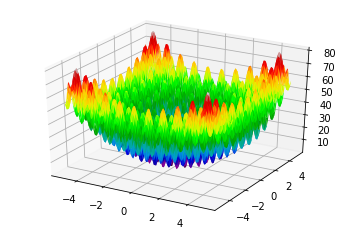

In [35]:
# Rastrigin

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm 
from mpl_toolkits.mplot3d import Axes3D 
 
X = np.linspace(-5.12, 5.12, 100)     
Y = np.linspace(-5.12, 5.12, 100)     
X, Y = np.meshgrid(X, Y) 

Z = (X**2 - 10 * np.cos(2 * np.pi * X)) + \
  (Y**2 - 10 * np.cos(2 * np.pi * Y)) + 20
 
fig = plt.figure() 
ax = fig.gca(projection='3d') 
ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
  cmap=cm.nipy_spectral, linewidth=0.08,
  antialiased=True)    
# plt.imshow(Z)
plt.show()

## Finding best Alpha1 and Alpha2

In [33]:
alpha1 = np.linspace(-6.5,6.5,30)
alpha2 = np.linspace(-6.5,6.5,30)
# w = np.linspace(0,1,100)
w = 30*[0.1]

# random_combinations = random.sample(set(itertools.product(w,alpha1,alpha2)), 1000)
all_possible_combinations = list(set(itertools.product(w,alpha1, alpha2)))

def automator(random_combinations):
    output = []
    for params in random_combinations:
            weight = params[0]
            alpha1 = params[1]
            alpha2 = params[2]
            best_score,num_runs = PSO(dim=2, w=weight, a1=alpha1, a2=alpha2, a3=1, population_size=3, time_steps=20, search_range=100).run()
            output.append((weight,alpha1,alpha2,best_score,num_runs))
    return output
            
    
result = automator(all_possible_combinations)

df = pd.DataFrame(result, columns=['w', 'alpha 1', 'alpha 2', 'best_score', 'num_runs'])
df.sort_values('best_score', inplace=True)
print(df)



       w   alpha 1   alpha 2    best_score  num_runs
898  0.1 -0.224138  2.913793  2.167676e+00        19
560  0.1  1.120690  2.017241  8.194351e+00        19
614  0.1  0.672414  2.465517  1.136525e+01        19
91   0.1  3.362069 -1.120690  1.408396e+01        19
573  0.1  0.224138  3.810345  1.664311e+01        19
..   ...       ...       ...           ...       ...
361  0.1 -2.465517  6.500000  7.630326e+06        19
302  0.1 -1.568966 -6.500000  8.100098e+06        20
874  0.1 -4.258621  5.603448  8.364724e+06        19
506  0.1  4.258621 -5.603448  9.244090e+06        20
593  0.1  6.051724 -6.500000  1.165356e+07        19

[900 rows x 5 columns]


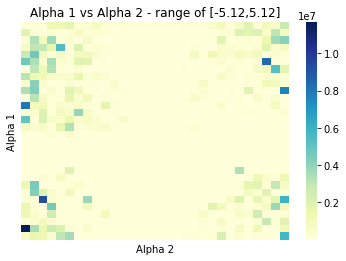

In [34]:
a1 = df.iloc[:,[1]]
a2 = df.iloc[:,[2]]
data = df.iloc[:,[1,2,3]]
data = data.pivot(index='alpha 1', columns='alpha 2', values='best_score')
sns.heatmap(data,xticklabels=False,yticklabels=False,cmap='YlGnBu')
# plt.imshow(data, cmap='hot', interpolation='nearest')
plt.title('Alpha 1 vs Alpha 2 - range of [-5.12,5.12]')
plt.xlabel("Alpha 2")
plt.ylabel("Alpha 1")


plt.savefig('alpha1_alpha2_rastrigin.pdf') 

plt.show()

### Plotting alpha1 vs alpha2

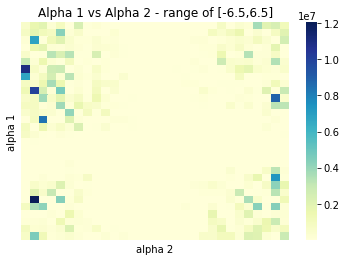

In [31]:
a1 = df.iloc[:,[1]]
a2 = df.iloc[:,[2]]
data = df.iloc[:,[1,2,3]]
data = data.pivot(index='alpha 1', columns='alpha 2', values='best_score')
sns.heatmap(data,xticklabels=False,yticklabels=False,cmap='YlGnBu')
plt.title('Alpha 1 vs Alpha 2 - range of [-6.5,6.5]')
plt.show()

## Finding best w

In [ ]:
# Now to find the best w - let us take the alpha values for which we got the best result:
best_result = df.iloc[[0],:]
print(best_result)
alpha1 = best_result.iloc[0]['alpha 1']
alpha2 = best_result.iloc[0]['alpha 2']

w = np.linspace(-1,1,30)

all_possible_combinations = list(set(itertools.product(w,30*[alpha1], 30*[alpha2])))

result = automator(all_possible_combinations)
df = pd.DataFrame(result, columns=['w', 'alpha 1', 'alpha 2', 'best_score'])
df.sort_values('w', inplace=True)

print(df)

w = df.iloc[:,[0]]
a1 = df.iloc[:,[1]]
a2 = df.iloc[:,[2]]
score = df.iloc[:,[3]]
data = df.iloc[:,[0,2,3]]
plt.plot(w,score)
# plt.imshow(data, cmap='hot', interpolation='nearest')
plt.title('W and its Score - range of [-1,1]')
plt.xlabel("W")
plt.ylabel("Score")


plt.savefig('w_rastrigin.pdf') 

plt.show()

### Performance based on N

In [ ]:
def automator_n(n_values,params):
    output = []
    for n in range(1,n_values):
        weight = params[0]
        alpha1 = params[1]
        alpha2 = params[2]
        best_score,num_runs = PSO(dim=10, w=weight, a1=alpha1, a2=alpha2, population_size=n, time_steps=1000, search_range=100).run()
        output.append((weight,alpha1,alpha2,best_score,num_runs,n))
    return output

params = [0.176552,2.295172,1.010167]
n_values = 100
result = automator_n(n_values,params)

df = pd.DataFrame(result, columns=['w', 'alpha 1', 'alpha 2', 'best_score', 'num_runs','n'])
df.sort_values('best_score', inplace=True)
print(df)

w = df.iloc[:,[0]]
a1 = df.iloc[:,[1]]
a2 = df.iloc[:,[2]]
score = df.iloc[:,[3]]
data = df.iloc[:,[0,2,3]]
n = df.iloc[:,[5]]
plt.plot(n,score)
# plt.imshow(data, cmap='hot', interpolation='nearest')
plt.title('Number of Particles and their Score - range of [1,100]')
plt.xlabel("Number of Particles")
plt.ylabel("Score")


plt.savefig('n_particles_rastrigin.pdf') 

plt.show()

In [ ]:
w = df.iloc[:,[0]]
a1 = df.iloc[:,[1]]
a2 = df.iloc[:,[2]]
score = df.iloc[:,[3]]
data = df.iloc[:,[0,2,3]]
n = df.iloc[:,[5]]
plt.plot(n,score)
# plt.imshow(data, cmap='hot', interpolation='nearest')
plt.title('Number of Particles and their Score - range of [1,100]')
plt.xlabel("Number of Particles")
plt.ylabel("Score")


plt.savefig('n_particles_rastrigin.pdf') 

plt.show()

### Performance based on D

In [ ]:
def automator_d(d_values,params):
    output = []
    for d in range(1,d_values):
        weight = params[0]
        alpha1 = params[1]
        alpha2 = params[2]
        best_score,num_runs = PSO(dim=d, w=weight, a1=alpha1, a2=alpha2, population_size=35, time_steps=1000, search_range=5.12).run()
        output.append((weight,alpha1,alpha2,best_score,num_runs,d))
    return output

params = [0.176552,2.295172,1.010167]
n_values = 100
result = automator_n(n_values,params)

df = pd.DataFrame(result, columns=['w', 'alpha 1', 'alpha 2', 'best_score', 'num_runs','d'])
df.sort_values('best_score', inplace=True)
print(df)

w = df.iloc[:,[0]]
a1 = df.iloc[:,[1]]
a2 = df.iloc[:,[2]]
score = df.iloc[:,[3]]
data = df.iloc[:,[0,2,3]]
d = df.iloc[:,[5]]
plt.plot(d,score)
# plt.imshow(data, cmap='hot', interpolation='nearest')
plt.title('Number of Dimensions and their Score - range of [1,100]')
plt.xlabel("Number of Dimensions")
plt.ylabel("Score")


plt.savefig('d_dimensions_rastrigin.pdf') 

plt.show()

In [ ]:
w = df.iloc[:,[0]]
a1 = df.iloc[:,[1]]
a2 = df.iloc[:,[2]]
score = df.iloc[:,[3]]
data = df.iloc[:,[0,2,3]]
d = df.iloc[:,[5]]
plt.plot(d,score)
# plt.imshow(data, cmap='hot', interpolation='nearest')
plt.title('Number of Dimensions and their Score - range of [1,100]')
plt.xlabel("Number of Dimensions")
plt.ylabel("Score")


plt.savefig('d_dimensions_rastrigin.pdf') 

plt.show()